# Classifer Grape Leaves using Transfering Learning 

## Banco de dados

In [ ]:
import os

# Lendo as crendenciais para download do dataset
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json

# Download do dataset
!kaggle datasets download -d muratkokludataset/grapevine-leaves-image-dataset

# #Descompressao do dataset
!unzip /content/grapevine-leaves-image-dataset.zip -d /content/kaggle/

 94% 102M/109M [00:01<00:00, 81.4MB/s] 
100% 109M/109M [00:01<00:00, 68.0MB/s]
Archive:  /content/grapevine-leaves-image-dataset.zip
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (1).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (10).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (100).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (11).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (12).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (13).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (14).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (15).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (16).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (17).png  
  inflating: /content/kaggle/Grapevine_Leaves_Image_Dataset/Ak/Ak (18).png  
  inflating: /conten

In [ ]:
import os
import numpy as np
import cv2
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


import tensorflow
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

tensorflow.__version__

'2.8.2'

## Dataframe  das imagens

In [ ]:
labels = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']
base_dir = '/content/kaggle/Grapevine_Leaves_Image_Dataset/'

print(os.listdir(base_dir))
path = []
label = []

for grape_class in os.listdir(base_dir):
    label_path = os.path.join(base_dir, grape_class)
    if grape_class in labels:
        for img in os.listdir(label_path):
            path.append(os.path.join(label_path, img))
            label.append(grape_class)



path = pd.Series(path)
labels = pd.Series(label)
img_data = pd.DataFrame({'Path':path.values, 'Label':labels.values})

print(img_data.head())
print(img_data.shape)


['Ak', 'Nazli', 'Buzgulu', 'Ala_Idris', 'Dimnit', 'Grapevine_Leaves_Image_Dataset_Citation_Request.txt']
                                                Path Label
0  /content/kaggle/Grapevine_Leaves_Image_Dataset...    Ak
1  /content/kaggle/Grapevine_Leaves_Image_Dataset...    Ak
2  /content/kaggle/Grapevine_Leaves_Image_Dataset...    Ak
3  /content/kaggle/Grapevine_Leaves_Image_Dataset...    Ak
4  /content/kaggle/Grapevine_Leaves_Image_Dataset...    Ak
(500, 2)


## Plotar as imagens

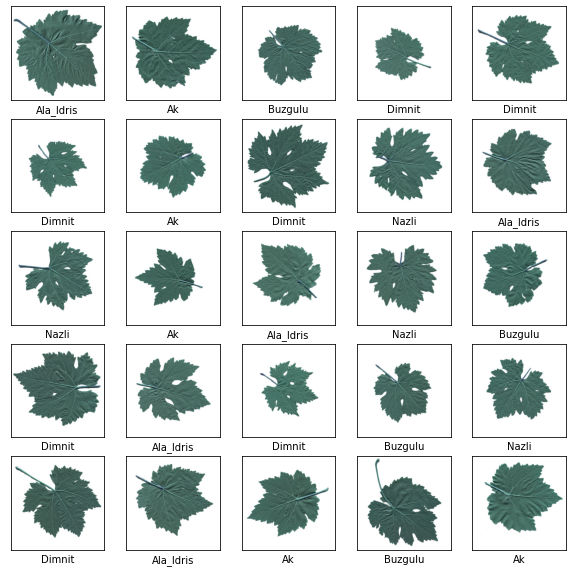

In [ ]:
plt.figure(figsize=(10,10))
rand_indicies = np.random.randint(len(img_data), size=25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = rand_indicies[i]
    plt.imshow(cv2.imread(img_data.iloc[index]['Path']), cmap=plt.cm.binary)
    plt.xlabel(img_data.iloc[index]['Label'])
plt.show()


## Label Encoder

É preciso transformar as calssificações das folhas em representações numéricas

In [ ]:
labelencoder = LabelEncoder()

img_data['Categorical'] = labelencoder.fit_transform(img_data['Label'])

## Separação do dataframe em treino e validação

O modelo de DL irá ser treinado com o train_df mas depois será confrotado com imagens inéditas.

In [ ]:
img_data = img_data.sample(frac=1).reset_index(drop=True)


train_df = img_data[:450]
valid_df = img_data[450:]

In [ ]:
img_size = 224

data = [] 

for img, label in zip(train_df['Path'], train_df['Categorical']):
  # print(img, label)
  img_arr = cv2.imread(img, cv2.IMREAD_COLOR)
  resized_arr = cv2.resize(img_arr, (img_size, img_size))
  data.append([resized_arr, label])


In [ ]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)


## Pré-Processamento 

In [ ]:
x = np.array(x) / 255

x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)


label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

## Modelo VGG19

In [ ]:
pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

model = Sequential([
    pre_trained_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(5 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 5)                 23045     
                                                                 
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
arquivo_modelo = 'modelo_VGG19_custom.json'
modelo_json = model.to_json()
with open(arquivo_modelo, 'w') as json_file:
  json_file.write(modelo_json)

In [ ]:
nome_modelo = 'modelo_VGG19_custom.h5'
checkpointer = ModelCheckpoint(nome_modelo, verbose=1, save_best_only=True) # Salvar os melhores modelos
early_stopper = EarlyStopping(patience = 5, monitor='val_loss')
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    min_lr=0.000001)
callbacks = [checkpointer, early_stopper, learning_rate_reduction]

In [ ]:
epochs = 15
batch_size = 64

history = model.fit(
    x_train,y_train, 
    batch_size = batch_size , 
    epochs = epochs , 
    validation_data = (x_test, y_test),
    callbacks = [callbacks])

Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 2.9191 - accuracy: 0.2333
Epoch 1: val_loss improved from inf to 1.54093, saving model to modelo_VGG19_custom.h5
6/6 [==============================] - 24s 2s/step - loss: 2.9191 - accuracy: 0.2333 - val_loss: 1.5409 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/15
6/6 [==============================] - ETA: 0s - loss: 1.4578 - accuracy: 0.4000
Epoch 2: val_loss improved from 1.54093 to 1.31180, saving model to modelo_VGG19_custom.h5
6/6 [==============================] - 3s 507ms/step - loss: 1.4578 - accuracy: 0.4000 - val_loss: 1.3118 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 3/15
6/6 [==============================] - ETA: 0s - loss: 1.2287 - accuracy: 0.5694
Epoch 3: val_loss improved from 1.31180 to 1.08960, saving model to modelo_VGG19_custom.h5
6/6 [==============================] - 3s 510ms/step - loss: 1.2287 - accuracy: 0.5694 - val_loss: 1.0896 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 4/15
6/6 [===============

## Avaliação do modelo

In [ ]:
print("Loss do modelo validacao - " , model.evaluate(x_test,y_test)[0])
print("Accuracy do modelo validacao - " , model.evaluate(x_test,y_test)[1]*100 , "%")

3/3 [==============================] - 3s 175ms/step - loss: 0.2337 - accuracy: 0.9222
Loss do modelo validacao -  0.2336685210466385
3/3 [==============================] - 1s 177ms/step - loss: 0.2337 - accuracy: 0.9222
Accuracy do modelo validacao -  92.22221970558167 %


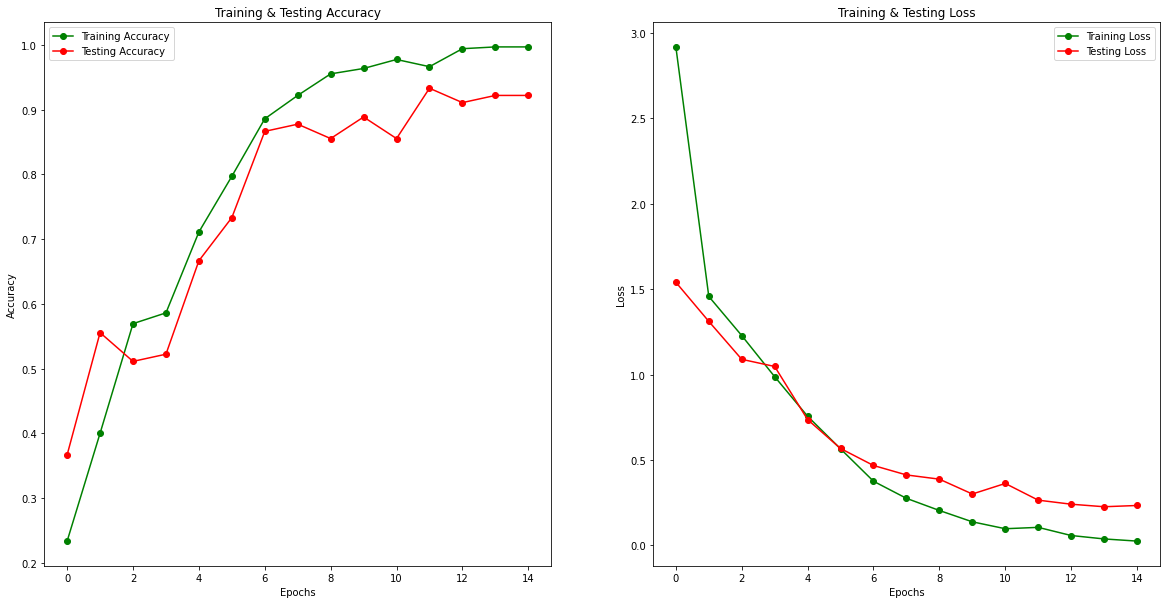

In [ ]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict(x_test)
print(np.argmax(model.predict(x_test), axis=-1))

[0 1 4 1 3 3 4 1 0 3 3 4 0 0 3 0 4 3 4 2 0 1 1 2 3 1 4 1 4 1 2 2 2 2 2 4 4
 3 1 1 1 0 2 2 0 1 3 4 2 4 0 3 4 2 3 1 4 1 2 2 0 1 2 0 2 1 3 0 4 2 3 3 3 4
 3 3 1 4 4 3 0 0 0 4 1 4 2 0 1 4]


In [ ]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.89      0.89      0.89        19
           2       0.94      0.89      0.91        18
           3       0.94      1.00      0.97        17
           4       0.90      1.00      0.95        18

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90



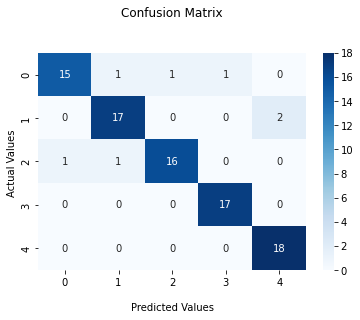

In [ ]:
ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)), annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

## verificar quais foram os acertos

Jogar em um dataset do pandas

In [ ]:
prop_class=[]

y_test_inv = label_binarizer.inverse_transform(y_test)

for i, classe in enumerate(y_test_inv):
  if(y_test_inv[i] == np.argmax(model.predict(x_test), axis=-1)[i]):
    #print(i, "Certo ", y_test_inv[i], ' - ', np.argmax(model.predict(x_test), axis=-1)[i])
    prop_class.append([i, "Certo ", y_test_inv[i], ' - ', np.argmax(model.predict(x_test), axis=-1)[i]])
  else:
    #print(i, "Errado ", y_test_inv[i], ' - ', np.argmax(model.predict(x_test), axis=-1)[i])
    prop_class.append([i, "Errado ", y_test_inv[i], ' - ', np.argmax(model.predict(x_test), axis=-1)[i]])


## Imagens ineditas

In [ ]:
valid_df.reset_index(inplace=True)

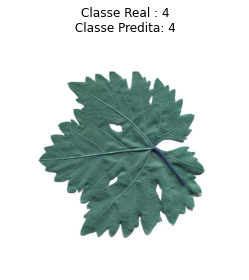

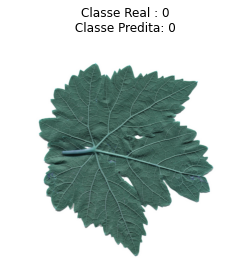

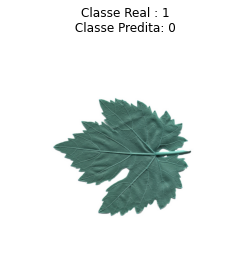

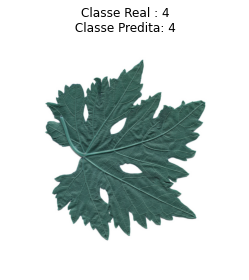

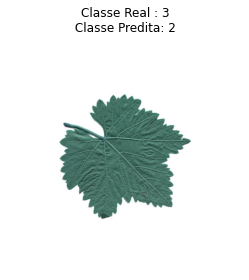

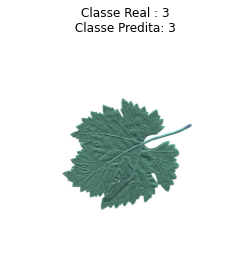

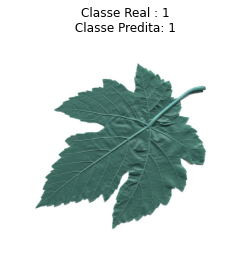

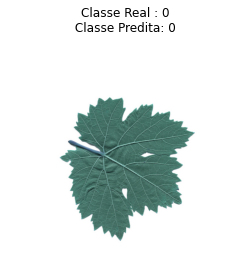

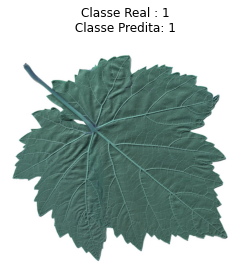

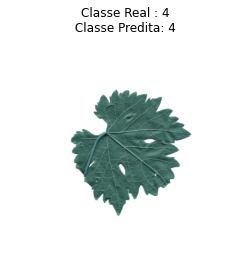

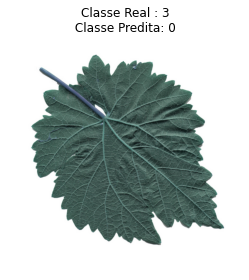

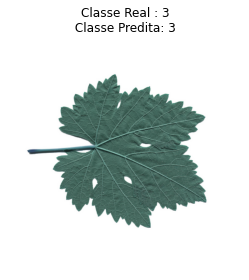

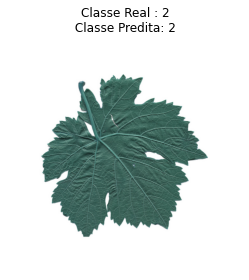

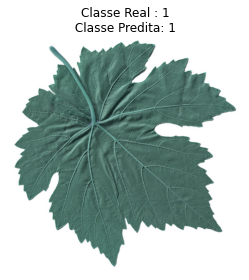

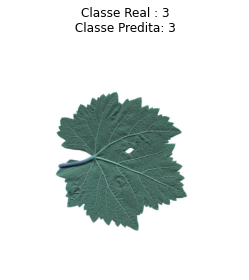

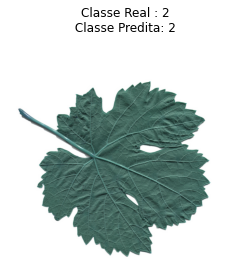

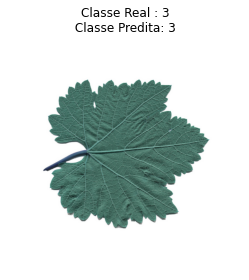

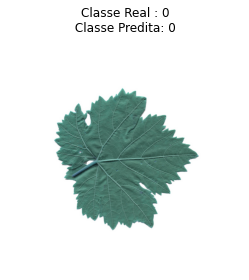

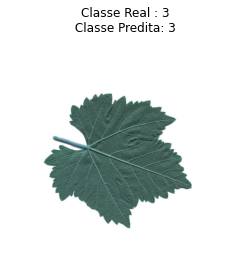

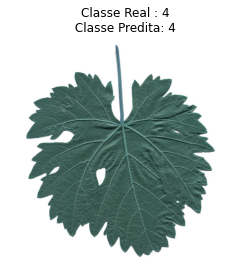

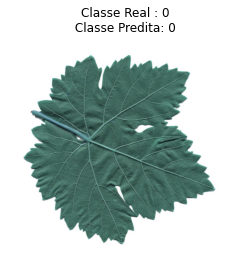

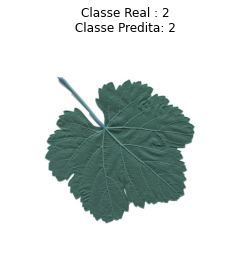

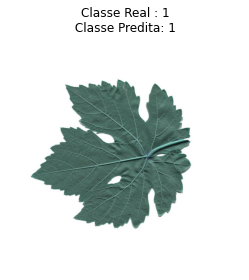

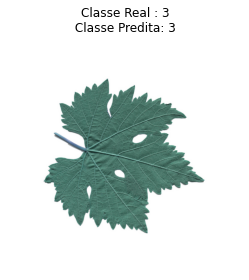

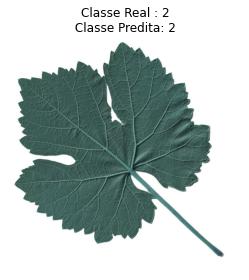

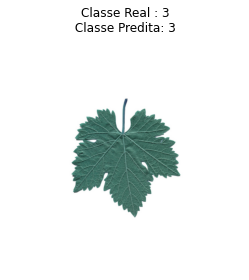

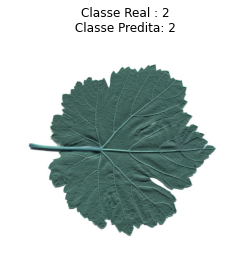

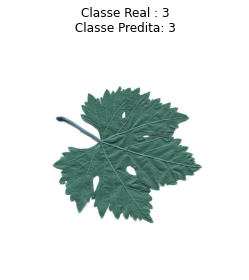

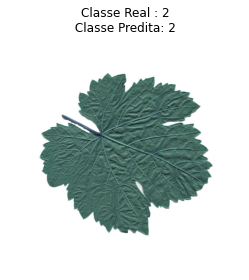

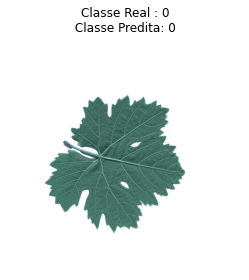

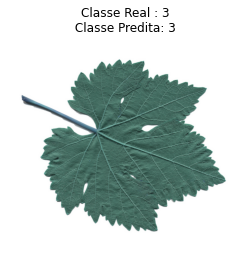

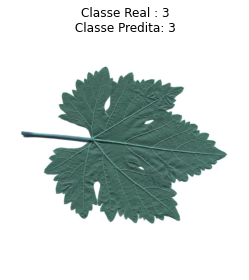

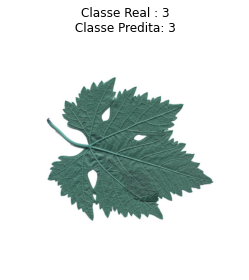

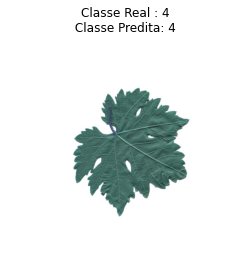

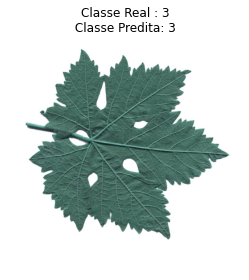

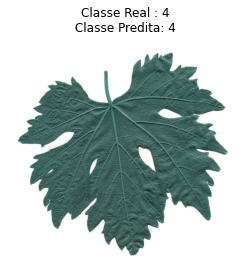

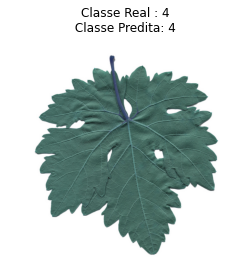

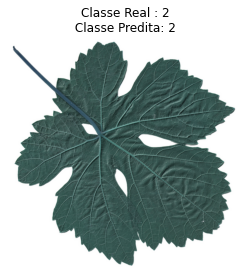

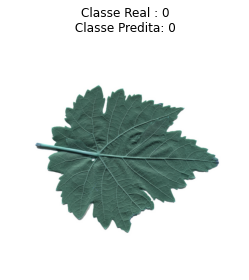

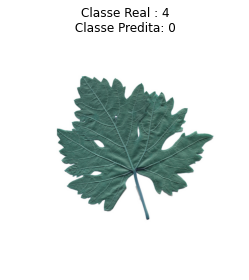

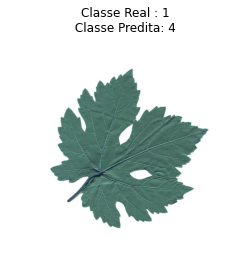

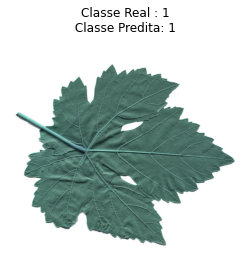

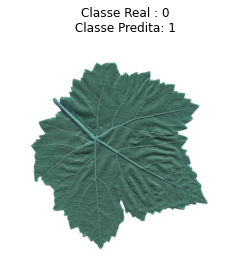

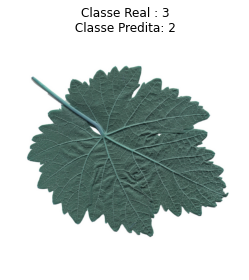

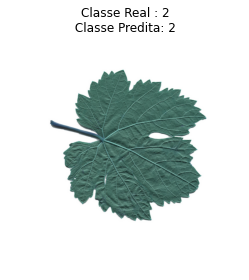

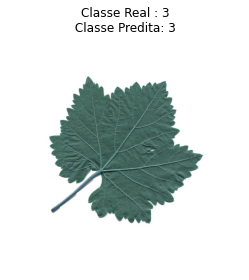

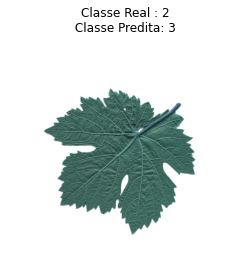

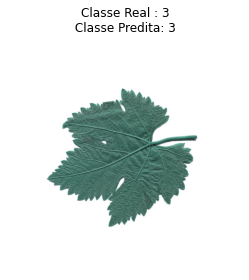

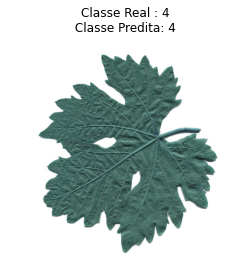

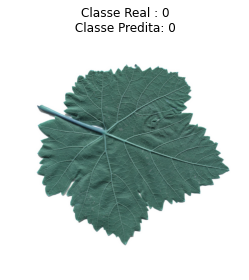

In [ ]:
for (i, classe), cat in zip(enumerate(valid_df['Path']), valid_df['Categorical']):
  img_test = cv2.imread(valid_df.iloc[i]['Path'], cv2.IMREAD_COLOR)
  resized_image_test= cv2.resize(img_test, (img_size, img_size))
  x = np.array(resized_image_test) / 255
  x = x.reshape(-1, img_size, img_size, 3)
  real_predictions = model.predict(x)
  plt.imshow(img_test)
  plt.axis('off')
  plt.title(f"Classe Real : {cat}\n Classe Predita: {np.argmax(real_predictions)} ")
  plt.tight_layout()
  plt.show()